In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [5]:
def circle_generator(num = 1):
    # generate circle with radiu (4,16) and center (0, 64)x(0, 64)
    _idx = np.zeros((2,64,64))
    _idx[0] = np.arange(64).reshape(64,1).repeat(64, axis = 1)
    _idx[1] = _idx[0].T
    
    output = np.zeros((num, 1, 64, 64))
    
    centers = 32*np.random.rand(num, 2) + 16
    square_radius = np.square(12*np.random.rand(num) + 4)
    
    for n in range(num):
        output[n, 0] = (np.square(_idx[0] - centers[n, 0]) + np.square(_idx[1] - centers[n, 1]) <= square_radius[n])
    
    output = torch.tensor(output.astype(np.float32))
    return output

class GNet(nn.Module):
    # generator
    def __init__(self):
        super(GNet, self).__init__()
        self.conv_trans_2d1 = nn.ConvTranspose2d(128, 64, 9)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv_trans_2d2 = nn.ConvTranspose2d(64, 32, 9)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv_trans_2d3 = nn.ConvTranspose2d(32, 16, 9)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv_trans_2d4 = nn.ConvTranspose2d(16, 1, 9)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv_trans_2d1(x)))
        x = F.relu(self.bn2(self.conv_trans_2d2(x)))
        x = F.relu(self.bn3(self.conv_trans_2d3(x)))
        x = torch.sigmoid(self.conv_trans_2d4(x))
        return x

class DNet(nn.Module):
    # discriminator
    def __init__(self):
        super(DNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 16, 5) # (64 - 4)/2 = 30
        self.conv2 = nn.Conv2d(16, 32, 3) # (30 - 2)/2 = 14
        self.fc1 = nn.Linear(32 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def d_criterion(outputs, labels):
    modify_outputs = 0.01 + outputs*0.98
    return -(labels*torch.log(modify_outputs) + (1-labels)*torch.log(1-modify_outputs)).mean()

def g_criterion(fack_object):
    return -torch.log(0.01 + 0.98*discriminator(fack_object)).mean()


In [6]:
datum_num = 500

d_epoch = 3
g_epoch = 3

generator = GNet()
discriminator = DNet()

true_circles = circle_generator(datum_num)
fake_circles = generator(2*torch.rand(datum_num, 128, 32, 32)-1).data

In [7]:
rounds = 20
for r in range(rounds):
    true_circles = true_circles[torch.randperm(datum_num)]
    true_circles[int(0.8*datum_num):] = circle_generator(datum_num - int(0.8*datum_num))
    fake_circles = fake_circles[torch.randperm(datum_num)]
    fake_circles[int(0.8*datum_num):] = generator(2*torch.rand(datum_num - int(0.8*datum_num), 128, 32, 32)-1).data
    circles = torch.cat((true_circles, fake_circles), 0)

    labels = torch.cat((torch.ones((datum_num, 1)), torch.zeros((datum_num, 1))), 0)

    d_data_set = torch.utils.data.TensorDataset(circles, labels)
    d_trainloader = torch.utils.data.DataLoader(d_data_set, batch_size=10, shuffle=True, num_workers=2)

    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.001, weight_decay = 0.0001)

    for e in range(d_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(d_trainloader, 0):
            inputs, labels = data
            inputs = Variable(inputs)
            labels = Variable(labels)
            d_optimizer.zero_grad()
            outputs = discriminator(inputs)
            loss = d_criterion(outputs, labels)
            loss.backward()
            d_optimizer.step()
            running_loss += loss.data
    
        print('round : %i, d_train epoch : %d, loss: %.3f' %(r + 1, e + 1 , running_loss / 100))


    g_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.001, weight_decay=0.0001)

    running_loss = 0.0

    for e in range(g_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(int(2*datum_num/10)):
            inputs = 2*torch.rand(10, 128, 32,32)-1
            g_optimizer.zero_grad()
            outputs = generator(inputs)
            loss = g_criterion(outputs)
            loss.backward()
            g_optimizer.step()
            running_loss += loss.data

        print('round : %i, g_train epoch : %d, loss: %.3f' %(r + 1, e + 1 , running_loss / 100))

print('Finished Training')

round : 1, d_train epoch : 1, loss: 0.051
round : 1, d_train epoch : 2, loss: 0.010
round : 1, d_train epoch : 3, loss: 0.010
round : 1, g_train epoch : 1, loss: 0.216
round : 1, g_train epoch : 2, loss: 0.010
round : 1, g_train epoch : 3, loss: 0.010
round : 2, d_train epoch : 1, loss: 0.055
round : 2, d_train epoch : 2, loss: 0.010
round : 2, d_train epoch : 3, loss: 0.010
round : 2, g_train epoch : 1, loss: 0.235
round : 2, g_train epoch : 2, loss: 0.010
round : 2, g_train epoch : 3, loss: 0.010
round : 3, d_train epoch : 1, loss: 0.157
round : 3, d_train epoch : 2, loss: 0.011
round : 3, d_train epoch : 3, loss: 0.011
round : 3, g_train epoch : 1, loss: 0.062
round : 3, g_train epoch : 2, loss: 0.010
round : 3, g_train epoch : 3, loss: 0.010
round : 4, d_train epoch : 1, loss: 0.048
round : 4, d_train epoch : 2, loss: 0.011
round : 4, d_train epoch : 3, loss: 0.010
round : 4, g_train epoch : 1, loss: 0.181
round : 4, g_train epoch : 2, loss: 0.010
round : 4, g_train epoch : 3, loss

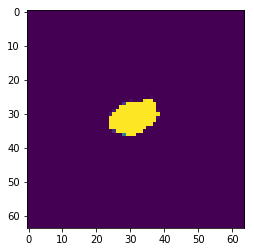

In [13]:
import matplotlib.pyplot as plt
plt.imshow(generator(2*torch.rand(1,128, 32, 32)-1).data[0,0])
plt.show()